In [1]:
import os
os.chdir("../../")

In [2]:
import scanpy as sc
import surgeon
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [33]:
acc_df = pd.read_csv("./results/classification/acc_df.csv")
acc_df.head()

,cell_type,trVAE,MLP,KNN,n_samples
0,PBMC T cells,0.982594,0.987124,0.074690,16776
1,PBMC CD4 T cells,0.975715,0.980852,0.573417,10706
2,PBMC CD56+ NK,0.992691,0.994411,0.812697,6978
3,PBMC CD8 T cells,0.978947,0.976692,0.958145,3990
4,PBMC CD19+ B cells,0.993203,0.992317,0.945331,3384


In [34]:
acc_df['cell_type'] = acc_df.cell_type.map(str) + f" (n = " + acc_df.n_samples.map(str) + ")"

In [35]:
cell_types = acc_df['cell_type'].values.tolist()

In [36]:
acc_df.head()

,cell_type,trVAE,MLP,KNN,n_samples
0,PBMC T cells (n = 16776),0.982594,0.987124,0.074690,16776
1,PBMC CD4 T cells (n = 10706),0.975715,0.980852,0.573417,10706
2,PBMC CD56+ NK (n = 6978),0.992691,0.994411,0.812697,6978
3,PBMC CD8 T cells (n = 3990),0.978947,0.976692,0.958145,3990
4,PBMC CD19+ B cells (n = 3384),0.993203,0.992317,0.945331,3384


In [37]:
plot_acc_df = pd.melt(acc_df, id_vars=['cell_type', 'n_samples'], var_name=['Method'], value_name='acc')

In [38]:
plot_acc_df.head()

,cell_type,n_samples,Method,acc
0,PBMC T cells (n = 16776),16776,trVAE,0.982594
1,PBMC CD4 T cells (n = 10706),10706,trVAE,0.975715
2,PBMC CD56+ NK (n = 6978),6978,trVAE,0.992691
3,PBMC CD8 T cells (n = 3990),3990,trVAE,0.978947
4,PBMC CD19+ B cells (n = 3384),3384,trVAE,0.993203


In [39]:
sns.set(style='whitegrid')

In [40]:
import matplotlib
font = {'family' : 'Arial',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=22)
matplotlib.rc('xtick', labelsize=22)

<Figure size 1080x360 with 0 Axes>

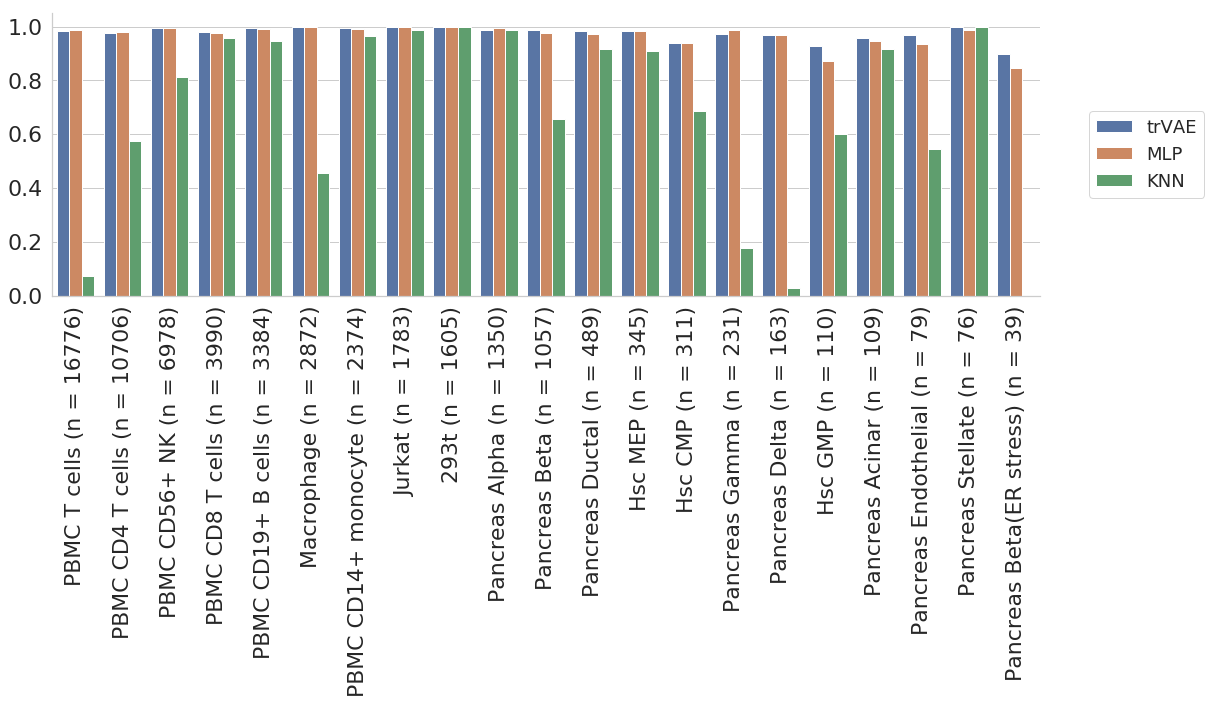

In [42]:
plt.close("all")
plt.figure(figsize=(15, 5))
g = sns.catplot(x="cell_type", y="acc",
                 hue="Method", legend=False,
                 data=plot_acc_df, kind="bar",
                 height=10, aspect=1.7);
plt.xlabel('', fontsize=22)
plt.ylabel("", fontsize=22)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05,0.5), borderaxespad=0, loc='center left', prop={'size': 18})
plt.tight_layout()
plt.savefig("./results/classification/accuracies_barplot.pdf", dpi=300)
plt.show()